# Introduction

The sizedistribution module contains various classes associated  with sizedistributions:
- SizeDist  - a one dimentional size distribution
- SizeDist_TS - size distribution time series
- SizeDist_LS - size distribution layer series
- OpticalProperties - optical properties derived from one of the sizedistribution classes above

All sizedistribution classes are relatives of each other with SizeDist beeing the parent. In other words SizeDist_TS and SizeDist_LS can do exactly the same things like SizeDist and a bit more.

In addition to the classes sizedistribution also contains a few usefull functions:
- simulate_sizedistribution, simulate_sizedistribution_timeseries, and simulate_sizedistribution_layerseries - the name speaks for themself.

# Imports

In [1]:
from atmPy.aerosols.size_distribution import sizedistribution as sd
from atmPy.general import timeseries
from atmPy.aerosols.instruments.piccolo import piccolo
from atmPy.tools import plt_tools
import pandas as pd
%matplotlib inline

# SizeDist

Due to the similarity to SizeDist_TS and SizeDist_LS I will skip this class. It will show up every now and then below.

# SizeDist_TS

## simulate size distribution 

In [2]:
dist = sd.simulate_sizedistribution_timeseries()

## Load a size distribution

Usually a SizeDistribution is generated by reading experimental data using a module designed for the particular instrument (pick one from in atmPy.instruments). The following is a size distribution recorded using a POPS instrument.

In [3]:
dist_TS = sd.read_csv('./data/POPS_dist_TS.csv')

/Users/htelg/prog/atm-py/atmPy/aerosols/size_distribution/sizedistribution.py:527: UserWarning: This function is deprecated use close_gaps instead ... unless you like thisone better
  _warnings.warn('This function is deprecated use close_gaps instead ... unless you like thisone better')


In [20]:
dist_TS.data.index.values

array(['2015-04-21T01:52:58.542969000-0600',
       '2015-04-21T01:52:59.539062000-0600',
       '2015-04-21T01:53:00.541016000-0600', ...,
       '2015-04-21T04:22:08.546875000-0600',
       '2015-04-21T04:22:09.542969000-0600',
       '2015-04-21T04:22:10.546875000-0600'], dtype='datetime64[ns]')

(<matplotlib.figure.Figure at 0x11001c240>,
 <matplotlib.colorbar.Colorbar at 0x110056518>)

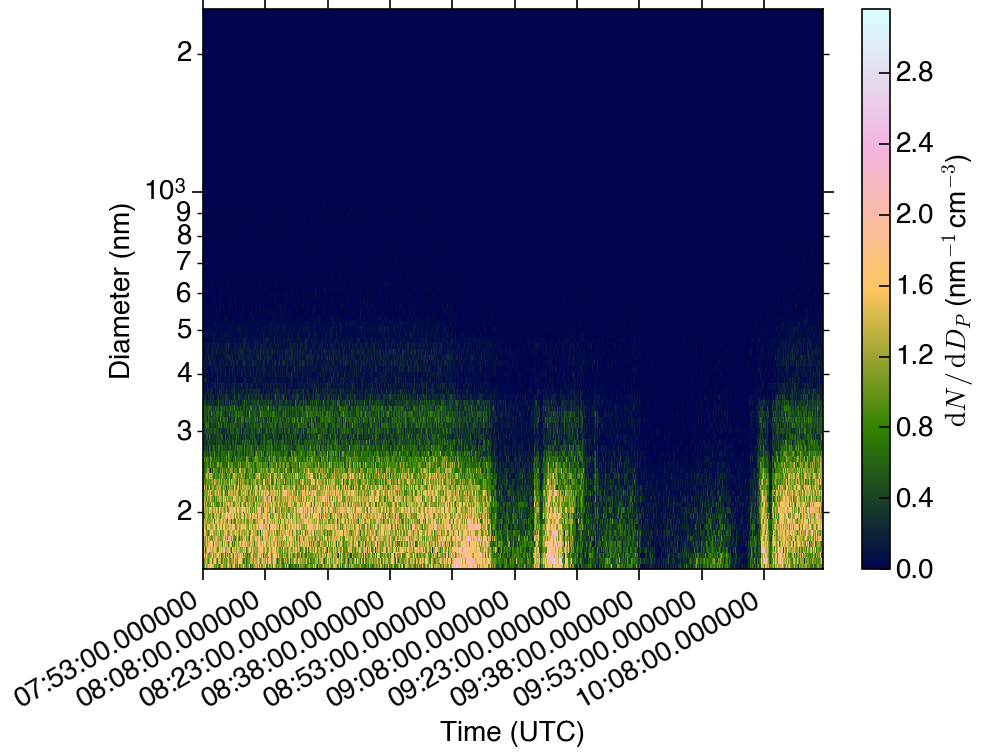

In [21]:
dist_TS.plot()

## Moment conversion

Current moment:

In [4]:
dist_TS.distributionType

'dNdDp'

<IPython.core.display.Javascript object>


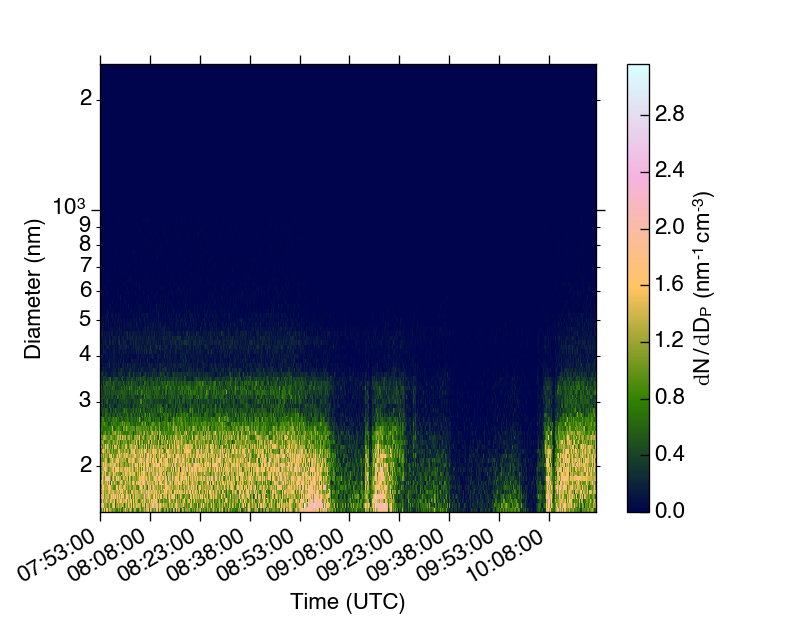

(<matplotlib.figure.Figure at 0x10656bd30>,
 <matplotlib.colorbar.Colorbar at 0x1053236d8>)

In [7]:
dist_TS.plot()

In [10]:
dist_TS = dist_TS.convert2dVdlogDp()

<IPython.core.display.Javascript object>


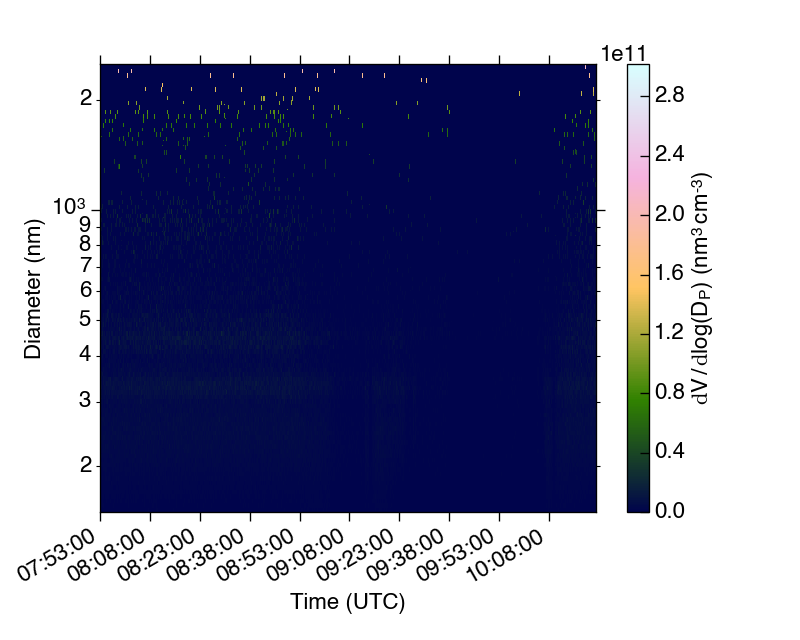

(<matplotlib.figure.Figure at 0x10dafad68>,
 <matplotlib.colorbar.Colorbar at 0x10fa66748>)

In [11]:
dist_TS.plot()

Now its different:

In [52]:
dist_TS.distributionType

'dNdlogDp'

There are plenty more, just play with the auto-completion.

## Fitting normal distribution to sizedistribution

This can take some time.

In [53]:
out = dist_TS.fit_normal()

See effect below in the plots

## Plottin stuff

All plotting functions will return matplotlib figures and axes, so further manipulation is possible.
The also have a lot of optional arguments that are worth exploring.

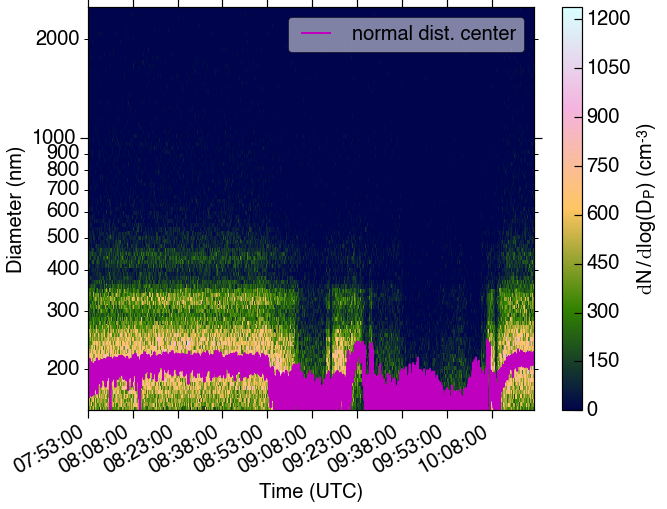

In [54]:
out = dist_TS.plot()

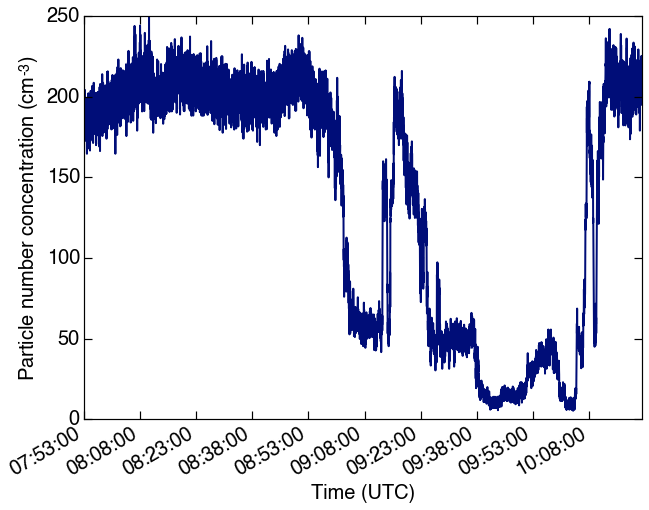

In [55]:
out = dist_TS.plot_particle_concentration()

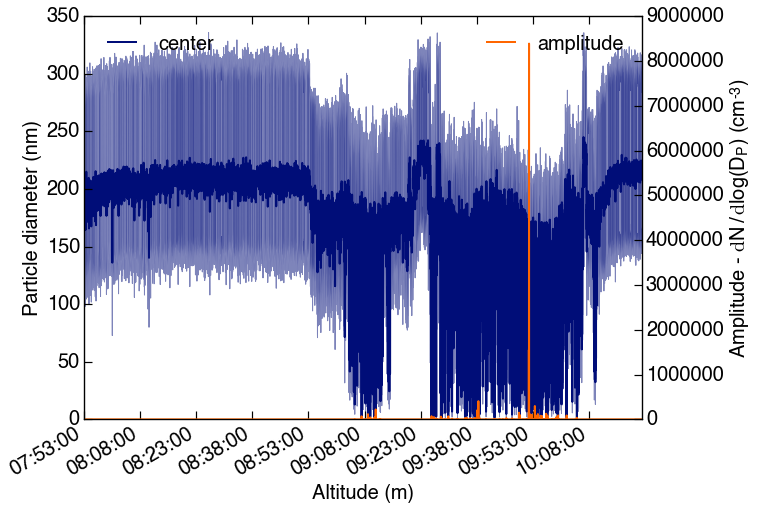

In [56]:
out = dist_TS.plot_fitres()

## Change time or diameter inteveral

In [57]:
dist_TS.get_timespan()

(Timestamp('2015-04-21 07:52:58.542969'),
 Timestamp('2015-04-21 10:22:10.546875'))

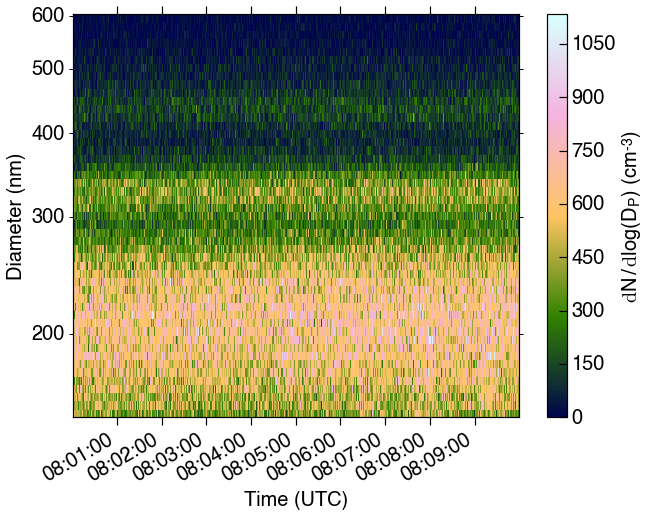

In [58]:
dt = dist_TS.zoom_time(start = '2015-04-21 08:00:00.00', end = '2015-04-21 08:10:00.00')
dt = dt.zoom_diameter(start = 150, end = 600)
out = dt.plot(fit_pos=False) 

## Averaging over time

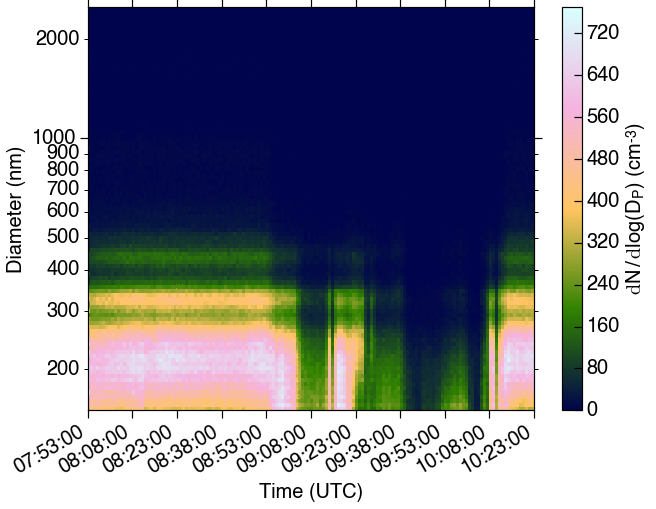

In [59]:
dt = dist_TS.average_overTime(window = '60S')
out = dt.plot(fit_pos=False)

The following will return a SizeDist instance since it is no longer a time series

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


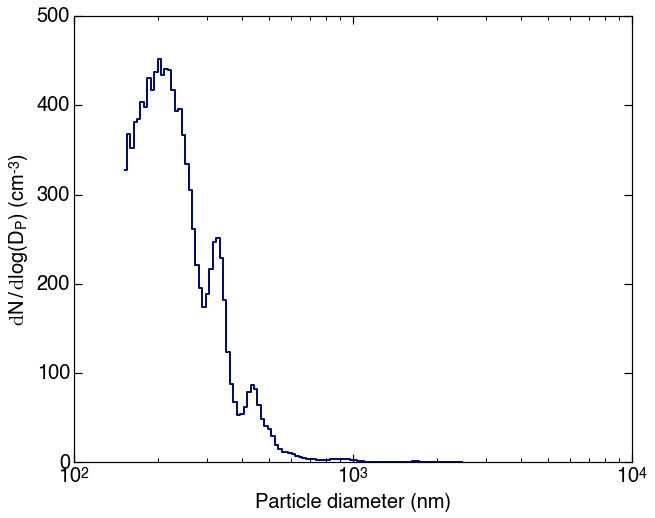

In [60]:
avg = dist_TS.average_overAllTime()
out = avg.plot()

# SizeDist_LS

## generating a SizeDist_LS instance

Before we can generate a layerseries we need a time series that contains information about Altitude. Furthermore we want to truncate the data to the timeperiode during which a vertical profile was taken.

In [75]:
from atmPy.instruments.Manta_payload import manta_payload

In [80]:
hk = piccolo.read_csv('./data/piccolo.log')
hk_II = manta_payload.read_csv('./data/Manta_raw.dat')
hk = hk.merge(hk_II)
spiral_up_start = '2015-04-21 08:20:54'
spiral_up_end = '2015-04-21 09:58:21'
dist_TS = dist_TS.zoom_time(spiral_up_start,spiral_up_end)
hk = hk.zoom_time(spiral_up_start,spiral_up_end)

The following will generate the SizeDist_LS instance with a layer thickness of 30 meters. (force is necessary since the Altitude time series is not monotonic)

In [81]:
dist_LS = dist_TS.convert2layerseries(hk, layer_thickness= 30, force = True)

/Users/htelg/prog/atm-py/atmPy/sizedistribution.py:1042: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  hk.data = hk.data.sort(columns='Altitude')
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


## Plotting stuff (LS)

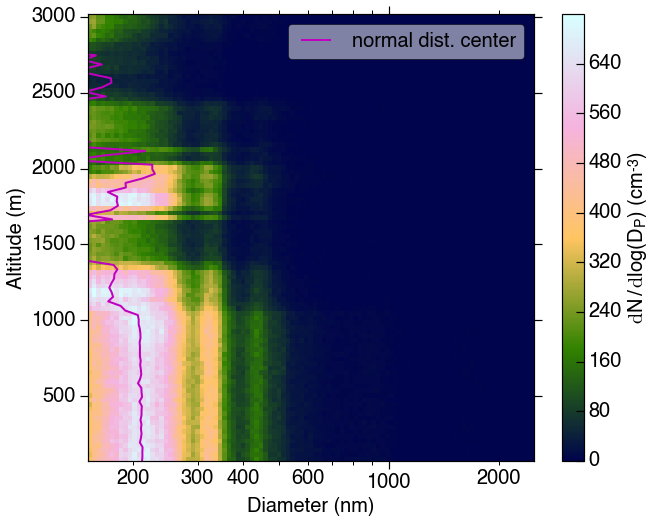

In [82]:
out = dist_LS.fit_normal()
out = dist_LS.plot()

## hygroscopic growth

Hygroscopic growth can either be applied with one RH value or by using the 'Relative_humidity' column in the associated housekeeping file. We made sure that this column exist by merging the file from the manta aircraft earlier.
Since the index of refraction is adjusted during the growth it is nesecarry to define that value before proceeding.

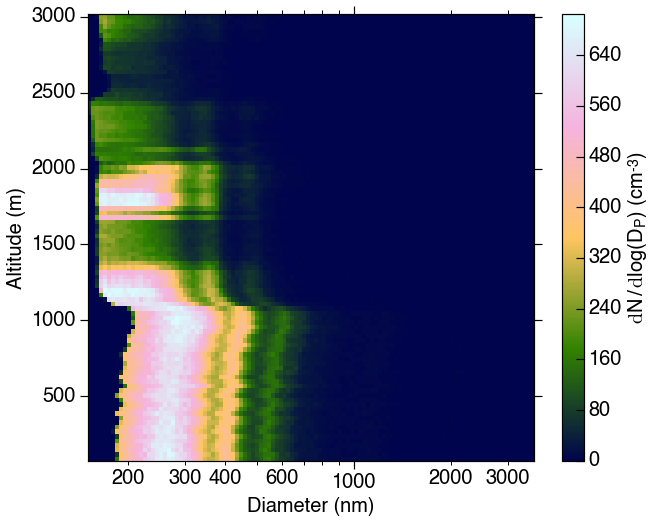

In [88]:
dist_LS.index_of_refraction = 1.455 # refractive index of the calibration material DOS
dist_LS_grown = dist_LS.apply_hygro_growth(0.5)
out = dist_LS_grown.plot(fit_pos=False)

# Optical properties

## generating OpticalProperties instance

To calculate optical properties it is again necessary to specify the refractive index, which we already did earlier. 

In [99]:
wavelength = 550
opt_prop = dist_LS.calculate_optical_properties(wavelength)

(<matplotlib.figure.Figure at 0x110a482e8>,
 <matplotlib.colorbar.Colorbar at 0x111054b38>)

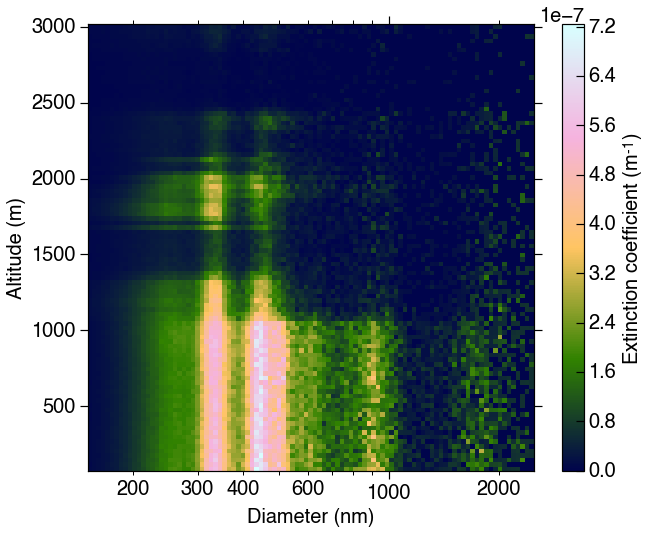

In [100]:
out = opt_prop.plot_extCoeffPerLayer()

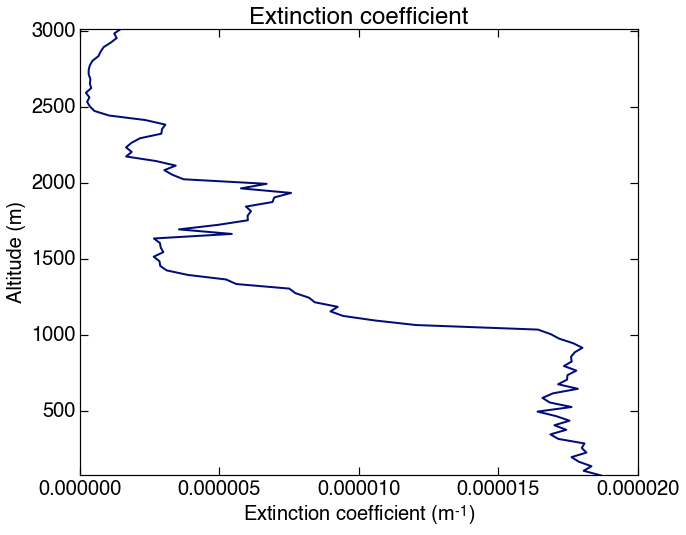

In [110]:
ext = opt_prop.get_extinction_coeff_verticle_profile()
ax = ext.plot()
ax.set_title('Extinction coefficient')

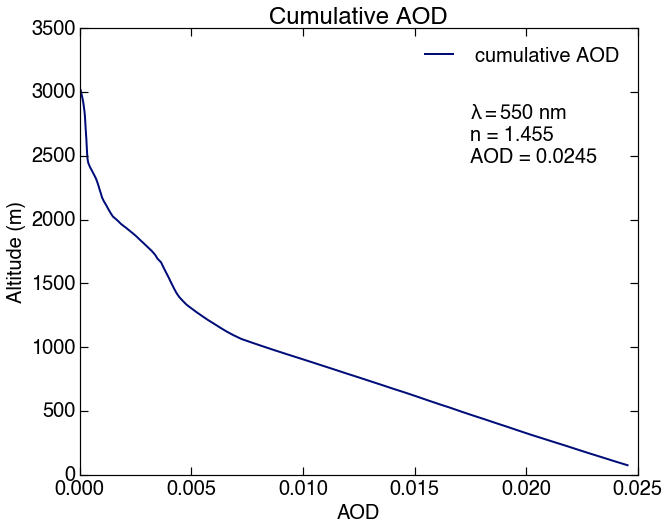

In [111]:
ax = opt_prop.plot_AOD_cum()
ax.set_title('Cumulative AOD')

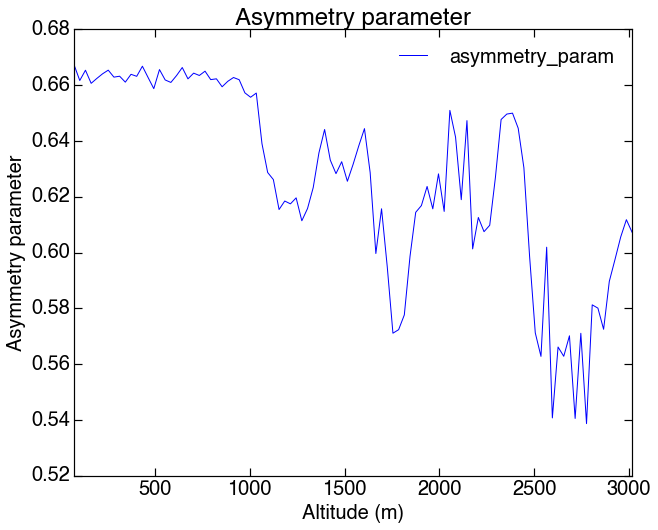

In [109]:
ax = opt_prop.asymmetry_parameter_LS.plot()
ax.set_xlabel('Altitude (m)')
ax.set_ylabel('Asymmetry parameter')
ax.set_title('Asymmetry parameter')